# **ANGGOTA KELOMPOK :**
### **1. M.ZHAFIR ZAYDAN (21.11.3913)**
### **2. VIKA NUR SAFITRI (21.11.3918)**
### **3. LUTHFA SOBRIAN PRAMASTA (21.11.3943)**
### **4. AHMAD JULIAN RIFKI (21.11.3964)**

LINK DATASET : https://www.kaggle.com/datasets/jagdishchavan/student-performance

Penjelasan Variable Dataset Student Performance:


1. gender : jenis kelamin siswa (laki-laki/perempuan)
2. race/ethnicity: etnisitas siswa -> (Kelompok A, B, C, D, E)
3. parental level of education: pendidikan terakhir orang tua -> (gelar sarjana, beberapa perguruan tinggi, gelar master, gelar sarjana muda, sekolah menengah atas)
4. lunch: makan siang sebelum tes (standar atau gratis/dikurangi)
5. test preparation course: lengkap atau tidak lengkap sebelum tes
6. math score: Skor Matematika
7. reading score: Skor membaca siswa
8. writing score: Skor menulis siswa




### **INSTALL PYSPARK**

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


### **IMPORT LIBRARY**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('Student').getOrCreate()
df = spark.read.csv('Z:\_𝐂𝐎𝐎𝐋𝐘𝐄𝐀𝐇_\𝗦𝗘𝗠𝗘𝗦𝗧𝗘𝗥 𝟱\BIG DATA LANJUT\TUGAS\FP\Dataset\StudentsPerformance.csv', header = True, inferSchema = True)
df.show()

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

In [3]:
df.count()

1000

### **PRE-PROCESSING**

In [4]:
# memeriksa tipe data
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)



In [5]:
# Melakukan perbaikan pada penamaan kolom
df_rename = df.withColumnRenamed("test preparation course", "prepare_exams")\
            .withColumnRenamed("parental level of education", "pendidikan_ortu")\
            .withColumnRenamed("race/ethnicity", "ras_etnis")\
            .withColumnRenamed("math score", "math_score")\
            .withColumnRenamed("reading score", "reading_score")\
            .withColumnRenamed("writing score", "writing_score")

In [6]:
df_rename.show()

+------+---------+------------------+------------+-------------+----------+-------------+-------------+
|gender|ras_etnis|   pendidikan_ortu|       lunch|prepare_exams|math_score|reading_score|writing_score|
+------+---------+------------------+------------+-------------+----------+-------------+-------------+
|female|  group B| bachelor's degree|    standard|         none|        72|           72|           74|
|female|  group C|      some college|    standard|    completed|        69|           90|           88|
|female|  group B|   master's degree|    standard|         none|        90|           95|           93|
|  male|  group A|associate's degree|free/reduced|         none|        47|           57|           44|
|  male|  group C|      some college|    standard|         none|        76|           78|           75|
|female|  group B|associate's degree|    standard|         none|        71|           83|           78|
|female|  group B|      some college|    standard|    completed|

In [7]:
# Menghitung jumlah nilai null pada tiap kolomnya
for column in df_rename.columns:
    count = df_rename.filter(df_rename[column].isNull()).count()
    print(f"The number of null values in the {column} column is : {count}")

The number of null values in the gender column is : 0
The number of null values in the ras_etnis column is : 0
The number of null values in the pendidikan_ortu column is : 0
The number of null values in the lunch column is : 0
The number of null values in the prepare_exams column is : 0
The number of null values in the math_score column is : 0
The number of null values in the reading_score column is : 0
The number of null values in the writing_score column is : 0


In [8]:
#Mengganti tipe data kolom ('math_score') menjadi double
student = df_rename.withColumn('math_score', df_rename.math_score.cast('double'))

student.printSchema()

root
 |-- gender: string (nullable = true)
 |-- ras_etnis: string (nullable = true)
 |-- pendidikan_ortu: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- prepare_exams: string (nullable = true)
 |-- math_score: double (nullable = true)
 |-- reading_score: integer (nullable = true)
 |-- writing_score: integer (nullable = true)



In [9]:
# Mendapatkan statistik deskriptif secara umum
student.summary().show()

+-------+------+---------+------------------+------------+-------------+------------------+------------------+-----------------+
|summary|gender|ras_etnis|   pendidikan_ortu|       lunch|prepare_exams|        math_score|     reading_score|    writing_score|
+-------+------+---------+------------------+------------+-------------+------------------+------------------+-----------------+
|  count|  1000|     1000|              1000|        1000|         1000|              1000|              1000|             1000|
|   mean|  NULL|     NULL|              NULL|        NULL|         NULL|            66.089|            69.169|           68.054|
| stddev|  NULL|     NULL|              NULL|        NULL|         NULL|15.163080096009454|14.600191937252223|15.19565701086966|
|    min|female|  group A|associate's degree|free/reduced|    completed|               0.0|                17|               10|
|    25%|  NULL|     NULL|              NULL|        NULL|         NULL|              57.0|      

In [10]:
numeric_features = [t[0] for t in student.dtypes if t[1] in ['int','double']]

# Mengambil kolom yang memiliki fitur numerik
numeric_summary = student.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+------------------+-----------------+
|summary|math_score        |reading_score     |writing_score    |
+-------+------------------+------------------+-----------------+
|count  |1000              |1000              |1000             |
|mean   |66.089            |69.169            |68.054           |
|stddev |15.163080096009454|14.600191937252223|15.19565701086966|
|min    |0.0               |17                |10               |
|25%    |57.0              |59                |57               |
|50%    |66.0              |70                |69               |
|75%    |77.0              |79                |79               |
|max    |100.0             |100               |100              |
+-------+------------------+------------------+-----------------+



In [11]:
import pandas as pd
pd.DataFrame(student.take(5), columns=student.columns).transpose()

,0,1,2,3,4
gender,female,female,female,male,male
ras_etnis,group B,group C,group B,group A,group C
pendidikan_ortu,bachelor's degree,some college,master's degree,associate's degree,some college
lunch,standard,standard,standard,free/reduced,standard
prepare_exams,none,completed,none,none,none
math_score,72.0,69.0,90.0,47.0,76.0
reading_score,72,90,95,57,78
writing_score,74,88,93,44,75


In [12]:
grouped_data = student.groupBy('prepare_exams').count()
grouped_data.show()

+-------------+-----+
|prepare_exams|count|
+-------------+-----+
|    completed|  358|
|         none|  642|
+-------------+-----+



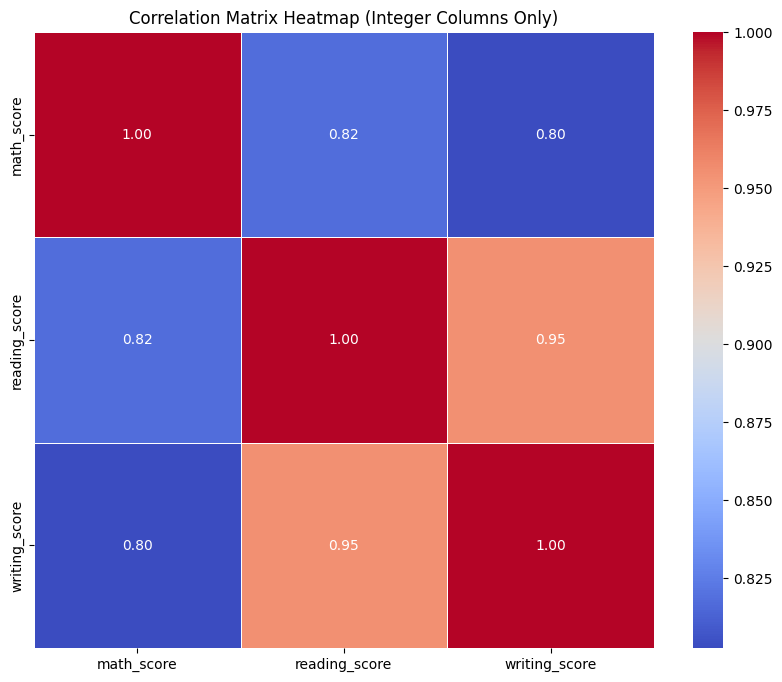

In [13]:
# menampilkan matriks korelasinya

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

integer_columns = [col_name for col_name, col_type in student.dtypes if col_type in ['int','double']]

vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")

for c in integer_columns:
    median_value = student.approxQuantile(c, [0.5], 0.0)[0]
    student = student.na.fill(median_value, [c])

vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")

df_assembled = vector_assembler.transform(student).select("features")

matrix = Correlation.corr(df_assembled, "features").head()
correlation_matrix = matrix[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix, columns=integer_columns, index=integer_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap (Integer Columns Only)")
plt.show()

Dari hasil Correlation Matrix Heatmap, kelompok kami mengambil 3 kolom saja karena hanya 3 kolom tersebut yang bertipe data numerik yaitu ('math_score', 'reading_score', 'writing_score') Maka, kolom yang kami pilih akan diuji coba menggunakan 4 Model Machine Learning.

### **CLASSIFICATION**

Klasifikasi ini bertujuan untuk memprediksi apakah siswa sudah kursus dan lengkap sebelum ujian (none/completed)

In [14]:
# Import modul-modul yang dibutuhkan dari Spark ML
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Daftar kolom-kolom kategori yang perlu diindeks dan dienkripsi
categoricalColumns = ['gender','ras_etnis','pendidikan_ortu','lunch']

# Inisialisasi list stages untuk menyimpan tahap-tahap transformasi
stages = []

# Loop untuk setiap kolom kategori
for categoricalCol in categoricalColumns:
    # StringIndexer mengonversi nilai kategori menjadi label numerik
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')

    # OneHotEncoder mengonversi label numerik menjadi vektor biner (one-hot encoding)
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    # Menambahkan tahapan StringIndexer dan OneHotEncoder ke dalam list stages
    stages += [stringIndexer, encoder]

# StringIndexer untuk kolom target ('prepare_exams'), mengonversi nilai target menjadi label numerik
label_stringIdx = StringIndexer(inputCol='prepare_exams', outputCol='label')
stages += [label_stringIdx]

# Kolom-kolom numerik yang tidak perlu diindeks atau dienkripsi
numericCols = ['math_score','reading_score','writing_score']

# Menentukan kolom-kolom input untuk VectorAssembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# VectorAssembler menggabungkan kolom-kolom input menjadi satu kolom vektor fitur ('features')
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Menambahkan tahap VectorAssembler ke dalam list stages
stages += [assembler]

### **PIPELINE**

In [15]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(student)
df_transformed = pipelineModel.transform(student)

selectedCols = ['label', 'features'] + student.columns
df_transformed = df_transformed.select(selectedCols)
df1 = df_transformed
df1.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- ras_etnis: string (nullable = true)
 |-- pendidikan_ortu: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- prepare_exams: string (nullable = true)
 |-- math_score: double (nullable = false)
 |-- reading_score: integer (nullable = true)
 |-- writing_score: integer (nullable = true)



In [16]:
pd.DataFrame(df1.take(5), columns=df1.columns).transpose()

,0,1,2,3,4
label,0.0,1.0,0.0,0.0,0.0
features,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
gender,female,female,female,male,male
ras_etnis,group B,group C,group B,group A,group C
pendidikan_ortu,bachelor's degree,some college,master's degree,associate's degree,some college
lunch,standard,standard,standard,free/reduced,standard
prepare_exams,none,completed,none,none,none
math_score,72.0,69.0,90.0,47.0,76.0
reading_score,72,90,95,57,78
writing_score,74,88,93,44,75


### **SPLIT DATA**

In [17]:
train, test = df1.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 838
Test Dataset Count: 162


### **PENGEMBANGAN MODEL MACHINE LEARNING**

### ***GRADIENT BOOST CLASSIFIER***

In [18]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[0.26202579714570...|       0.0|[0.62809467546953...|
|female|         none|[0.46326485698383...|       0.0|[0.71637070963203...|
|female|         none|[0.60396757562514...|       0.0|[0.76993339395514...|
|female|         none|[0.39252860519452...|       0.0|[0.68676903372143...|
|female|         none|[1.05780929597093...|       0.0|[0.89241198079109...|
|female|         none|[0.22800491889802...|       0.0|[0.61206717296426...|
|female|         none|[0.96976834208196...|       0.0|[0.87430123455900...|
|female|         none|[0.52662152103945...|       0.0|[0.74139716583805...|
|female|         none|[0.37507623600906...|       0.0|[0.67921192115715...|
|female|         none|[-0.0742376336261...|       1.0|[0.46294922326298...|
+------+----

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'labels' adalah nilai yang diprediksi dan label sebenarnya
# Misalnya, predictions = model.transform(test_data), labels = test_data.select('label').collect()

# Inisialisasi evaluator
evaluator = BinaryClassificationEvaluator()

# Hitung nilai Area Under ROC
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_array = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
labels_array = [int(row.label) for row in predictions.select('label').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(labels_array, predictions_array) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(labels_array, predictions_array) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(labels_array, predictions_array) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(labels_array, predictions_array) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = predictions.filter(predictions['label'] != predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 75.01%


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 184.0 failed 1 times, most recent failure: Lost task 0.0 in stage 184.0 (TID 161) (192.168.56.1 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


### ***FACTORIZATION MACHINES CLASSIFIER***

In [ ]:
from pyspark.ml.classification import FMClassifier

fmc = FMClassifier(featuresCol = 'features', labelCol = 'label', stepSize=0.001)
fmcModel = fmc.fit(train)
predictions = fmcModel.transform(test)
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[1.54610641827931...|       0.0|[0.82435066606324...|
|female|         none|[0.57412335654199...|       0.0|[0.63971407272964...|
|female|         none|[0.47073246241056...|       0.0|[0.61555710576228...|
|female|         none|[1.17109906490213...|       0.0|[0.76334361941543...|
|female|         none|[0.91433986466060...|       0.0|[0.71388741173842...|
|female|         none|[0.81736895731956...|       0.0|[0.69367755753352...|
|female|         none|[1.17214514868849...|       0.0|[0.76353254253425...|
|female|         none|[0.87633799011468...|       0.0|[0.70606278833961...|
|female|         none|[0.94133151339765...|       0.0|[0.71936853843652...|
|female|         none|[-0.2293853831856...|       1.0|[0.44290379064192...|
+------+----

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'labels' adalah nilai yang diprediksi dan label sebenarnya
# Misalnya, predictions = model.transform(test_data), labels = test_data.select('label').collect()

# Inisialisasi evaluator
evaluator = BinaryClassificationEvaluator()

# Hitung nilai Area Under ROC
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_array = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
labels_array = [int(row.label) for row in predictions.select('label').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(labels_array, predictions_array) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(labels_array, predictions_array) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(labels_array, predictions_array) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(labels_array, predictions_array) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = predictions.filter(predictions['label'] != predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 81.73%
Akurasi: 71.60%
Nilai F1-score: 52.08%
Presisi: 67.57%
Recall: 42.37%
+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[1.54610641827931...|       0.0|[0.82435066606324...|
|female|         none|[0.57412335654199...|       0.0|[0.63971407272964...|
|female|         none|[0.47073246241056...|       0.0|[0.61555710576228...|
|female|         none|[1.17109906490213...|       0.0|[0.76334361941543...|
|female|         none|[0.91433986466060...|       0.0|[0.71388741173842...|
|female|         none|[0.81736895731956...|       0.0|[0.69367755753352...|
|female|         none|[1.17214514868849...|       0.0|[0.76353254253425...|
|female|         none|[0.87633799011468...|       0.0|[0.70606278833961...|
|female|         none|[0.94133151339765...|       0.0|[0.719368538

### ***RANDOM FOREST CLASSIFIER***

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[16.5074851416157...|       0.0|[0.82537425708078...|
|female|         none|[11.3799213741360...|       0.0|[0.56899606870680...|
|female|         none|[11.4333670567452...|       0.0|[0.57166835283726...|
|female|         none|[12.5059131172784...|       0.0|[0.62529565586392...|
|female|         none|[16.7497529013319...|       0.0|[0.83748764506659...|
|female|         none|[14.2788842729895...|       0.0|[0.71394421364947...|
|female|         none|[16.0766535419534...|       0.0|[0.80383267709767...|
|female|         none|[13.3257700830248...|       0.0|[0.66628850415124...|
|female|         none|[10.4599966980827...|       0.0|[0.52299983490413...|
|female|         none|[9.24705512005050...|       1.0|[0.46235275600252...|
+------+----

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'labels' adalah nilai yang diprediksi dan label sebenarnya
# Misalnya, predictions = model.transform(test_data), labels = test_data.select('label').collect()

# Inisialisasi evaluator
evaluator = BinaryClassificationEvaluator()

# Hitung nilai Area Under ROC
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_array = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
labels_array = [int(row.label) for row in predictions.select('label').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(labels_array, predictions_array) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(labels_array, predictions_array) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(labels_array, predictions_array) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(labels_array, predictions_array) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = predictions.filter(predictions['label'] != predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 73.33%
Akurasi: 72.22%
Nilai F1-score: 50.55%
Presisi: 71.88%
Recall: 38.98%
+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[16.5074851416157...|       0.0|[0.82537425708078...|
|female|         none|[11.3799213741360...|       0.0|[0.56899606870680...|
|female|         none|[11.4333670567452...|       0.0|[0.57166835283726...|
|female|         none|[12.5059131172784...|       0.0|[0.62529565586392...|
|female|         none|[16.7497529013319...|       0.0|[0.83748764506659...|
|female|         none|[14.2788842729895...|       0.0|[0.71394421364947...|
|female|         none|[16.0766535419534...|       0.0|[0.80383267709767...|
|female|         none|[13.3257700830248...|       0.0|[0.66628850415124...|
|female|         none|[10.4599966980827...|       0.0|[0.522999834

### ***LOGISTIC REGRESSION***

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=20)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[3.06490397069697...|       0.0|[0.95542162974757...|
|female|         none|[-0.0981232478259...|       1.0|[0.47548885135079...|
|female|         none|[0.14795694907195...|       0.0|[0.53692190624647...|
|female|         none|[2.44761247760195...|       0.0|[0.92038668051649...|
|female|         none|[3.46280166449445...|       0.0|[0.96961062888518...|
|female|         none|[1.40171760754574...|       0.0|[0.80245630547548...|
|female|         none|[3.06236039987949...|       0.0|[0.95531317058861...|
|female|         none|[1.83035549282942...|       0.0|[0.86180407069230...|
|female|         none|[2.18313345114046...|       0.0|[0.89872463119227...|
|female|         none|[-1.0659292938919...|       1.0|[0.25617799040449...|
+------+----

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'labels' adalah nilai yang diprediksi dan label sebenarnya
# Misalnya, predictions = model.transform(test_data), labels = test_data.select('label').collect()

# Inisialisasi evaluator
evaluator = BinaryClassificationEvaluator()

# Hitung nilai Area Under ROC
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_array = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
labels_array = [int(row.label) for row in predictions.select('label').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(labels_array, predictions_array) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(labels_array, predictions_array) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(labels_array, predictions_array) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(labels_array, predictions_array) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = predictions.filter(predictions['label'] != predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 86.52%
Akurasi: 78.40%
Nilai F1-score: 71.07%
Presisi: 69.35%
Recall: 72.88%
+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[3.06490397069697...|       0.0|[0.95542162974757...|
|female|         none|[-0.0981232478259...|       1.0|[0.47548885135079...|
|female|         none|[0.14795694907195...|       0.0|[0.53692190624647...|
|female|         none|[2.44761247760195...|       0.0|[0.92038668051649...|
|female|         none|[3.46280166449445...|       0.0|[0.96961062888518...|
|female|         none|[1.40171760754574...|       0.0|[0.80245630547548...|
|female|         none|[3.06236039987949...|       0.0|[0.95531317058861...|
|female|         none|[1.83035549282942...|       0.0|[0.86180407069230...|
|female|         none|[2.18313345114046...|       0.0|[0.898724631

### Kami menggunakan 4 Model Machine Learning Classification yaitu :
- Gradient Boost Classifier
- Factorization Machines Classifier
- Random Forest Classifier
- Logistic Regression

Kelompok kami menggunakan 4 model tersebut karena dataset yang kami pilih memiliki label dua class saja bukan multiclass, jadi model yang cocok untuk dua class tersebut adalah ke 4 model yang kami coba tersebut.


Hasil dari Model yang kami latih sangat bervariasi:                    
1. **Gradient Boost Classifier**:                             
(Test Area Under ROC: 75.01%)                              
(Akurasi: 70.99%)                            
(Nilai F1-score: 53.47%)                             
(Presisi: 64.29%)                                  
(Recall: 45.76%)       

2. **Factorization Machines Classifier:**                            
(Test Area Under ROC: 81.73%)            
(Akurasi: 71.60%)                     
(Nilai F1-score: 52.08%)                   
(Presisi: 67.57%)                    
(Recall: 42.37%)                                                                      

3. **Random Forest Classifier:**                                   
(Test Area Under ROC: 74.44%)                             
(Akurasi: 74.07%)                         
(Nilai F1-score: 54.35%)                       
(Presisi: 75.76%)                      
(Recall: 42.37%)                                                      

4. **Logistic Regression:**                                       
(Test Area Under ROC: 86.52%)                         
(Akurasi: 78.40%)                   
(Nilai F1-score: 71.07%)                    
(Presisi: 69.35%)                   
(Recall: 72.88%)           




Dari ke 4 Model yang sudah kami latih tersebut, kami memilih 2 model yang terbaik untuk di Hyperparameter Tuning yaitu:
- Random Forest Classifier
- Logistic Regression

### **TUNING MODEL**

### **TUNING LOGISTIC REGRESSION**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create Logistic Regression Classifier
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.7, 1.0])
             .addGrid(lr.maxIter, [10, 20, 30, 50])
             .addGrid(lr.threshold, [0.3, 0.5, 0.7])
             .build())


# Initialize evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='f1'
)

# Initialize evaluator Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedPrecision'
)

# Initialize evaluator Recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedRecall'
)

# Initialize CrossValidator with LogisticRegression and ParamGrid
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator_f1, numFolds=5)

# Train the model using training data
cvModel = cv.fit(train)

# Make predictions using test data
lrpredictions = cvModel.transform(test)

# Evaluate AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator_auc.evaluate(lrpredictions)
print(f'AUC: {auc * 100:.3f}%')  # Display AUC in percentage

# Evaluate Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator_accuracy.evaluate(lrpredictions)
print(f'Accuracy: {accuracy:.3%}')

# Evaluate F1-Score
f1_score = evaluator_f1.evaluate(lrpredictions)
print(f'F1-Score: {f1_score:.3%}')

# Evaluate Precision
precision = evaluator_precision.evaluate(lrpredictions)
print(f'Precision: {precision:.3%}')

# Evaluate Recall
recall = evaluator_recall.evaluate(lrpredictions)
print(f'Recall: {recall:.3%}')

# Display some predictions
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Count and display the number of incorrect predictions
wrong_predictions = predictions.filter(lrpredictions['label'] != lrpredictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')

AUC: 85.453%
Accuracy: 77.778%
F1-Score: 77.263%
Precision: 77.397%
Recall: 77.778%
+------+-------------+--------------------+----------+--------------------+
|gender|prepare_exams|       rawPrediction|prediction|         probability|
+------+-------------+--------------------+----------+--------------------+
|female|         none|[2.28174256090356...|       0.0|[0.90735363582426...|
|female|         none|[0.41621360479613...|       0.0|[0.60257684467590...|
|female|         none|[0.39114305725941...|       0.0|[0.59655783675076...|
|female|         none|[1.45647163387929...|       0.0|[0.81099242710759...|
|female|         none|[2.36723395626650...|       0.0|[0.91429436111079...|
|female|         none|[1.09326488389546...|       0.0|[0.74899602182808...|
|female|         none|[1.85452901925805...|       0.0|[0.86465798531603...|
|female|         none|[1.05607506872145...|       0.0|[0.74193977165509...|
|female|         none|[1.08358432580234...|       0.0|[0.74717168423522...|
|fem

### **TUNING FACTOR MACHINES CLASSIFIER**

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create Random Forest Classifier
fmc = FMClassifier(featuresCol='features', labelCol='label')

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(fmc.factorSize, [50, 100, 150]) # Lebih banyak faktor
             .addGrid(fmc.stepSize, [0.005, 0.01, 0.05]) # Lebih kecil langkah
             .addGrid(fmc.maxIter, [20, 50, 100]) # Lebih banyak iterasi
             .addGrid(fmc.regParam, [0.05, 0.1, 0.5]) # Regularisasi lebih kecil
             .addGrid(fmc.miniBatchFraction, [0.1, 0.5, 1.0]) # Ukuran mini batch
             .build())


# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='f1'
)

# Initialize CrossValidator with RandomForestClassifier and ParamGrid
cv = CrossValidator(estimator=fmc, estimatorParamMaps=paramGrid, evaluator=evaluator_f1, numFolds=5)

# Train the model using training data
cvModel = cv.fit(train)

# Make predictions using test data
fmcpredictions = cvModel.transform(test)

# Evaluate AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator_auc.evaluate(fmcpredictions)
print(f'AUC: {auc * 100:.3f}%')  # Display AUC in percentage

# Evaluate Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator_accuracy.evaluate(fmcpredictions)
print(f'Accuracy: {accuracy:.3%}')

# Evaluate F1-Score
f1_score = evaluator_f1.evaluate(fmcpredictions)
print(f'F1-Score: {f1_score:.3%}')

# Evaluate Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedPrecision'
)
precision = evaluator_precision.evaluate(fmcpredictions)
print(f'Precision: {precision:.3%}')

# Evaluate Recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedRecall'
)
recall = evaluator_recall.evaluate(fmcpredictions)
print(f'Recall: {recall:.3%}')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
predictions.select('gender', 'prepare_exams', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = predictions.filter(fmcpredictions['label'] != fmcpredictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')